<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/Anomaly_detection_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection in Tensorflow
The notebook follows this tutorial: https://www.youtube.com/watch?v=2K3ScZp1dXQ
<p>with Laurence Moroney - AI Lead, Google

## How to use machine lerning to resolve if a piece of data is anomalous?

### **insead of this:**

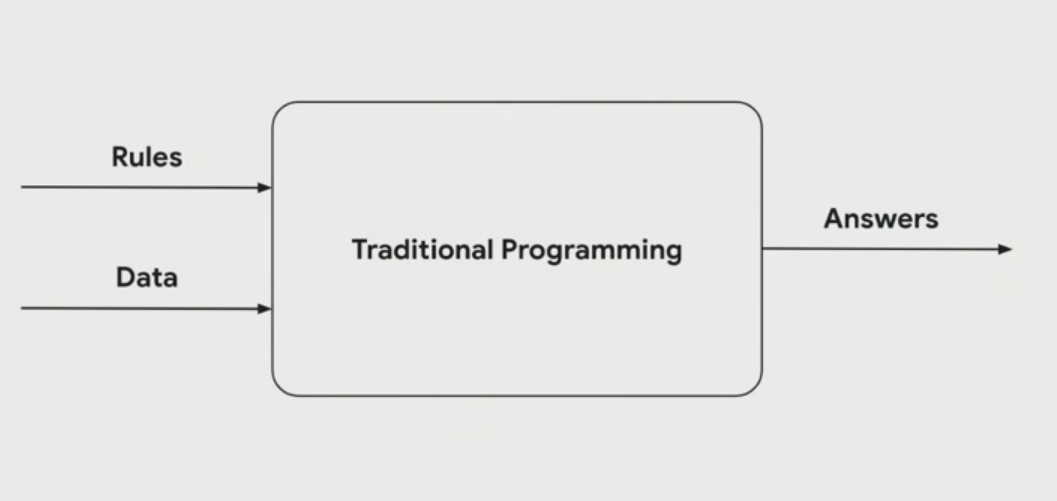

### **use this:**

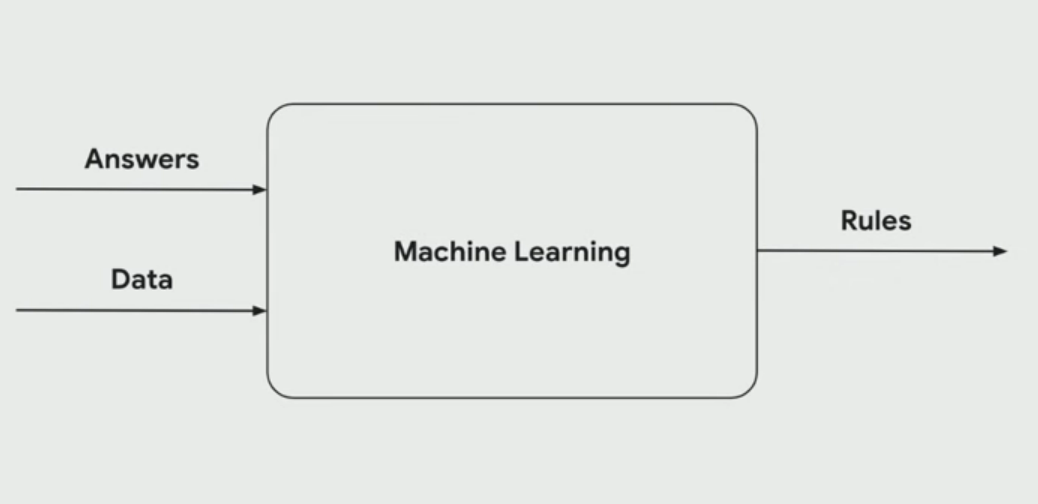

### **we will use Auto-Encoder architecture**

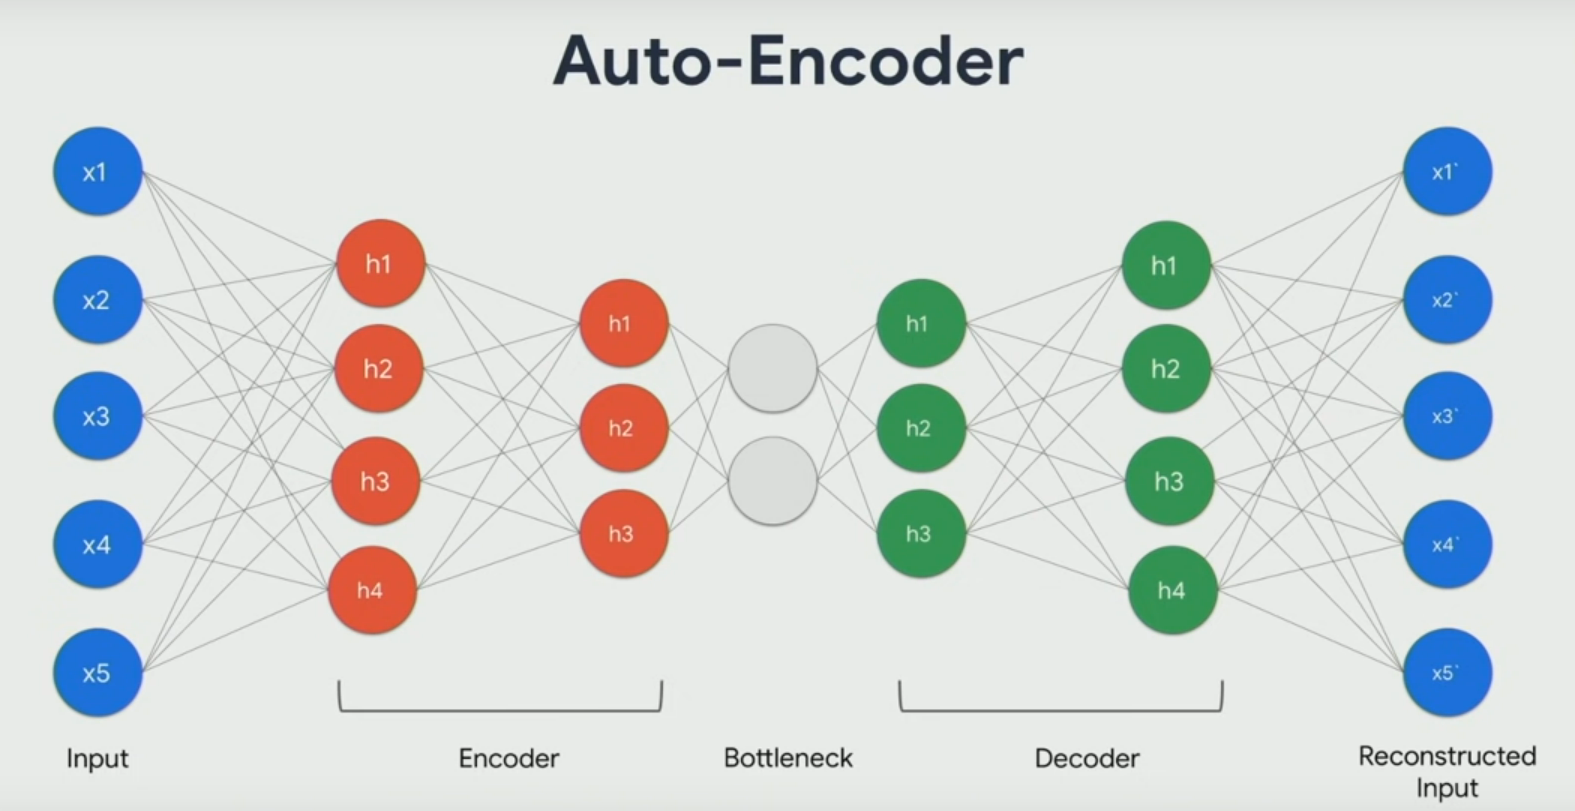

In [ ]:
# Import modules
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense

# Create a DigitEncoder class for MNIST dataset
class DigitEncoder(Model):
  def __init__(self):
    super(DigitEncoder, self).__init__()
    self.encoder = Sequential([
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu')
    ])
    self.decoder = Sequential([
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(784, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

<p> This architecture learns to reconstruct samples of data from a given set.
<p> When anomalous data is introduced to the trained model, the model does poor job and hence we know that the data is anomalous.
<p> Variational Auto-Encoders (image below) are used for anomaly detection applications. The Author of the workshop claims that it is better to use a model with less generalization capabilities (I myself think this choice is good for this particular usage).   

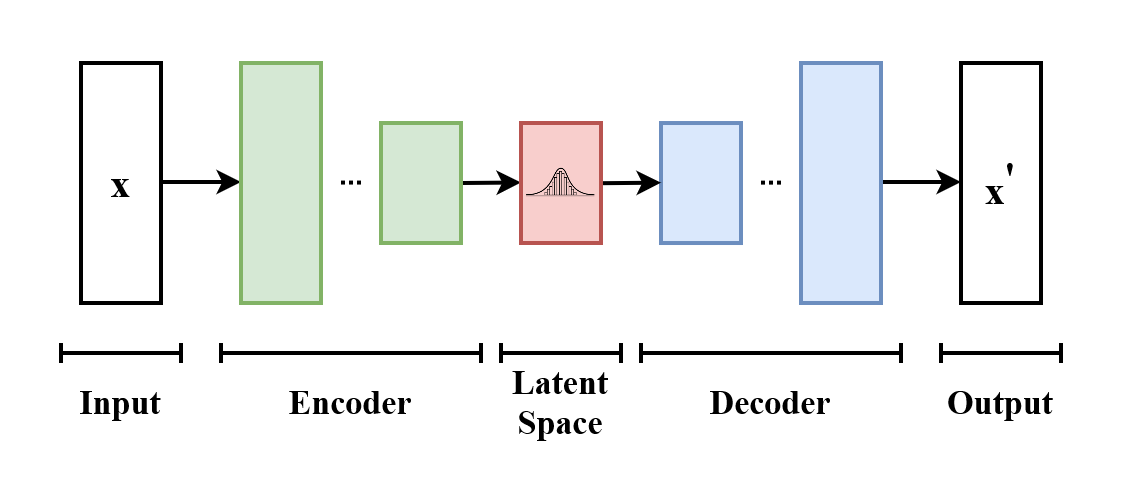

[Source: Wikipedia]

## Download and prepare the ECG data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download the dataset
ECG_df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = ECG_df.values
ECG_df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
raw_data.shape

(4998, 141)

In [ ]:
ECG_df.iloc[:,140].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [ ]:
# Create label and feture arrays
labels = raw_data[:, -1]
features = raw_data[:, :-1]

labels.shape, features.shape

((4998,), (4998, 140))

In [ ]:
# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=.2, random_state=21)

In [ ]:
# Normalize the data on the train set
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

print(min_val, max_val)

train_data_norm = (train_data - min_val) / (max_val - min_val)
test_data_norm = (test_data - min_val) / (max_val - min_val)

print(train_data_norm.dtype, test_data_norm.dtype)

tf.Tensor(-6.2808752, shape=(), dtype=float64) tf.Tensor(7.4021031, shape=(), dtype=float64)
<dtype: 'float64'> <dtype: 'float64'>


In [ ]:
# Change datsets' dtypes to float32 and bool
train_data_norm = tf.cast(train_data_norm, tf.float32)
test_data_norm = tf.cast(test_data_norm, tf.float32)

train_labels_bool = train_labels.astype(bool)
test_labels_bool = test_labels.astype(bool)

print(train_labels_bool.shape, sum(train_labels_bool))

(3998,) 2359


In [ ]:
# Separate datasets into normal and abnormal datasets
normal_train_data = train_data_norm[train_labels_bool]
normal_test_data = test_data_norm[test_labels_bool]

abnormal_train_data = train_data_norm[~train_labels_bool]
abnormal_test_data = test_data_norm[~test_labels_bool]


### MY OWN HELPER FUNCTIONS

In [ ]:
def draw_samples(dataset, n):
  return tf.gather(dataset, indices=np.random.randint(dataset.shape[0], size=n), axis=0)

def plot_random_samples(dataset, n):
  samples = draw_samples(dataset, n)
  sns.set_style('darkgrid')

  col_number=1
  if n % np.sqrt(n) == 0:
    col_number = int(np.sqrt(n))
  for divider in np.arange(6, 2, -1, dtype=np.int8):
    if n % divider == 0:
      col_number = divider
      break

  row_number = int((n / col_number))

  fig, axes = plt.subplots(ncols=col_number, nrows=row_number, sharey=True, sharex=True, figsize=(6*col_number, 4*row_number))

  for it, axis in enumerate(fig.get_axes()):
    axis.plot(range(samples.shape[1]), samples[it])


  plt.tight_layout()
  plt.show()


In [ ]:
def plot_curves_with_regression(history, order=[2,2]):

    '''
    Uses seaborn and to plot curves
    as scatterplot with regression
    attrs:
    history: history object
    order: order of regression curve
    default order=2
    '''

    # Create DataFrame
    df = pd.DataFrame(history.history)

    # Setup the figure
    plt.figure(figsize=(32, 8))
    plt.suptitle(f'Model {history.model.name} metrics', fontsize='x-large')

    # Plot loss
    plt.subplot(1, 2, 1)
    sns.regplot(x='index', y='loss', data=df.reset_index(),
                order=order[0], label='Training Loss')
    sns.regplot(x='index', y='val_loss', data=df.reset_index(),
                order=order[0], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    sns.regplot(x='index', y='accuracy', data=df.reset_index(),
                order=order[1], label='Training Accuracy')
    sns.regplot(x='index', y='val_accuracy', data=df.reset_index(),
                order=order[1], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

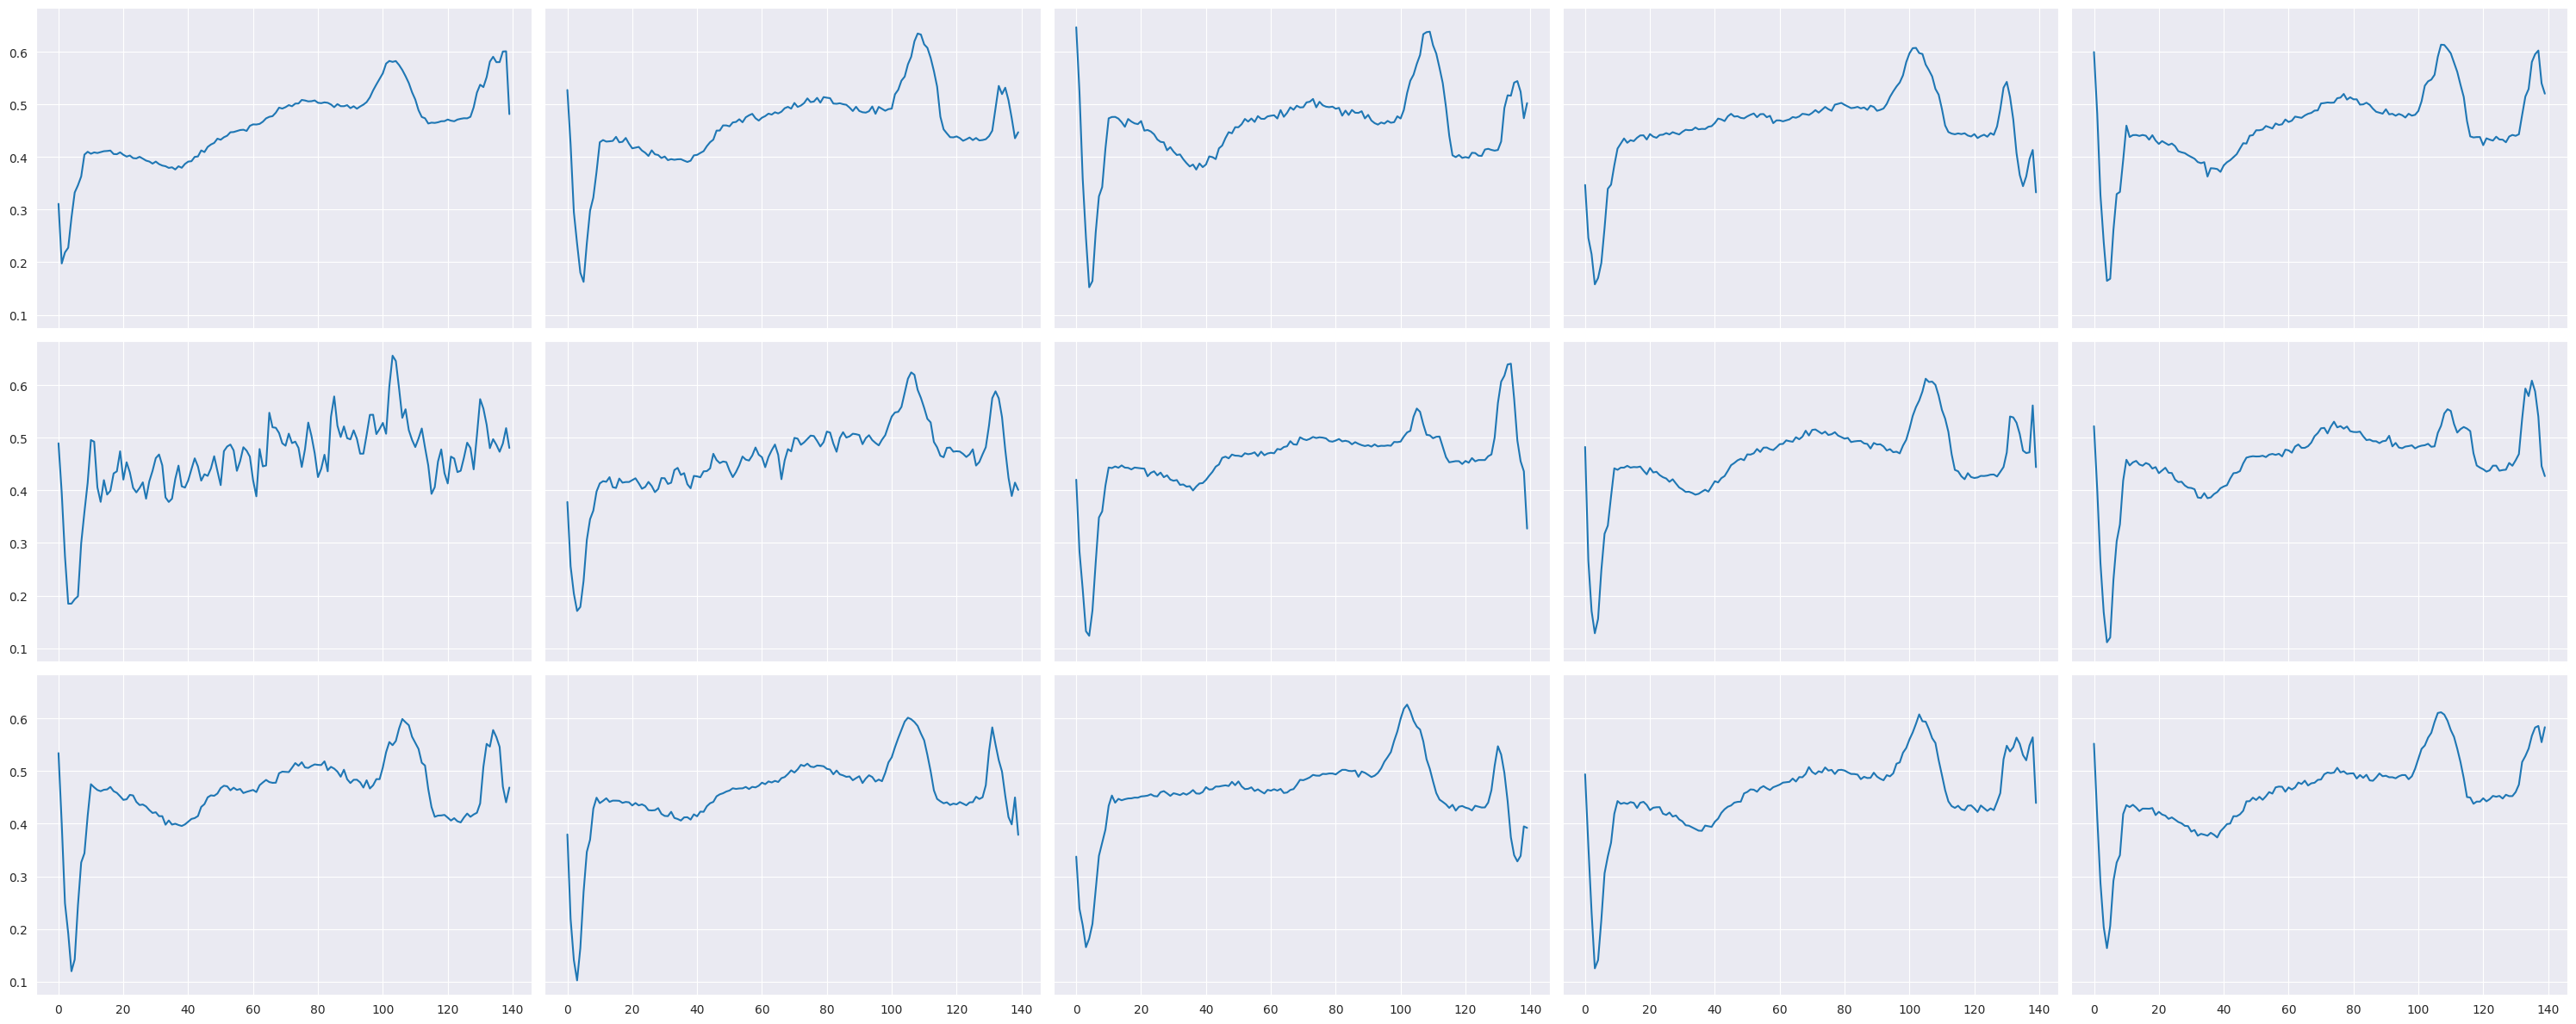

In [ ]:
plot_random_samples(normal_train_data, 15)

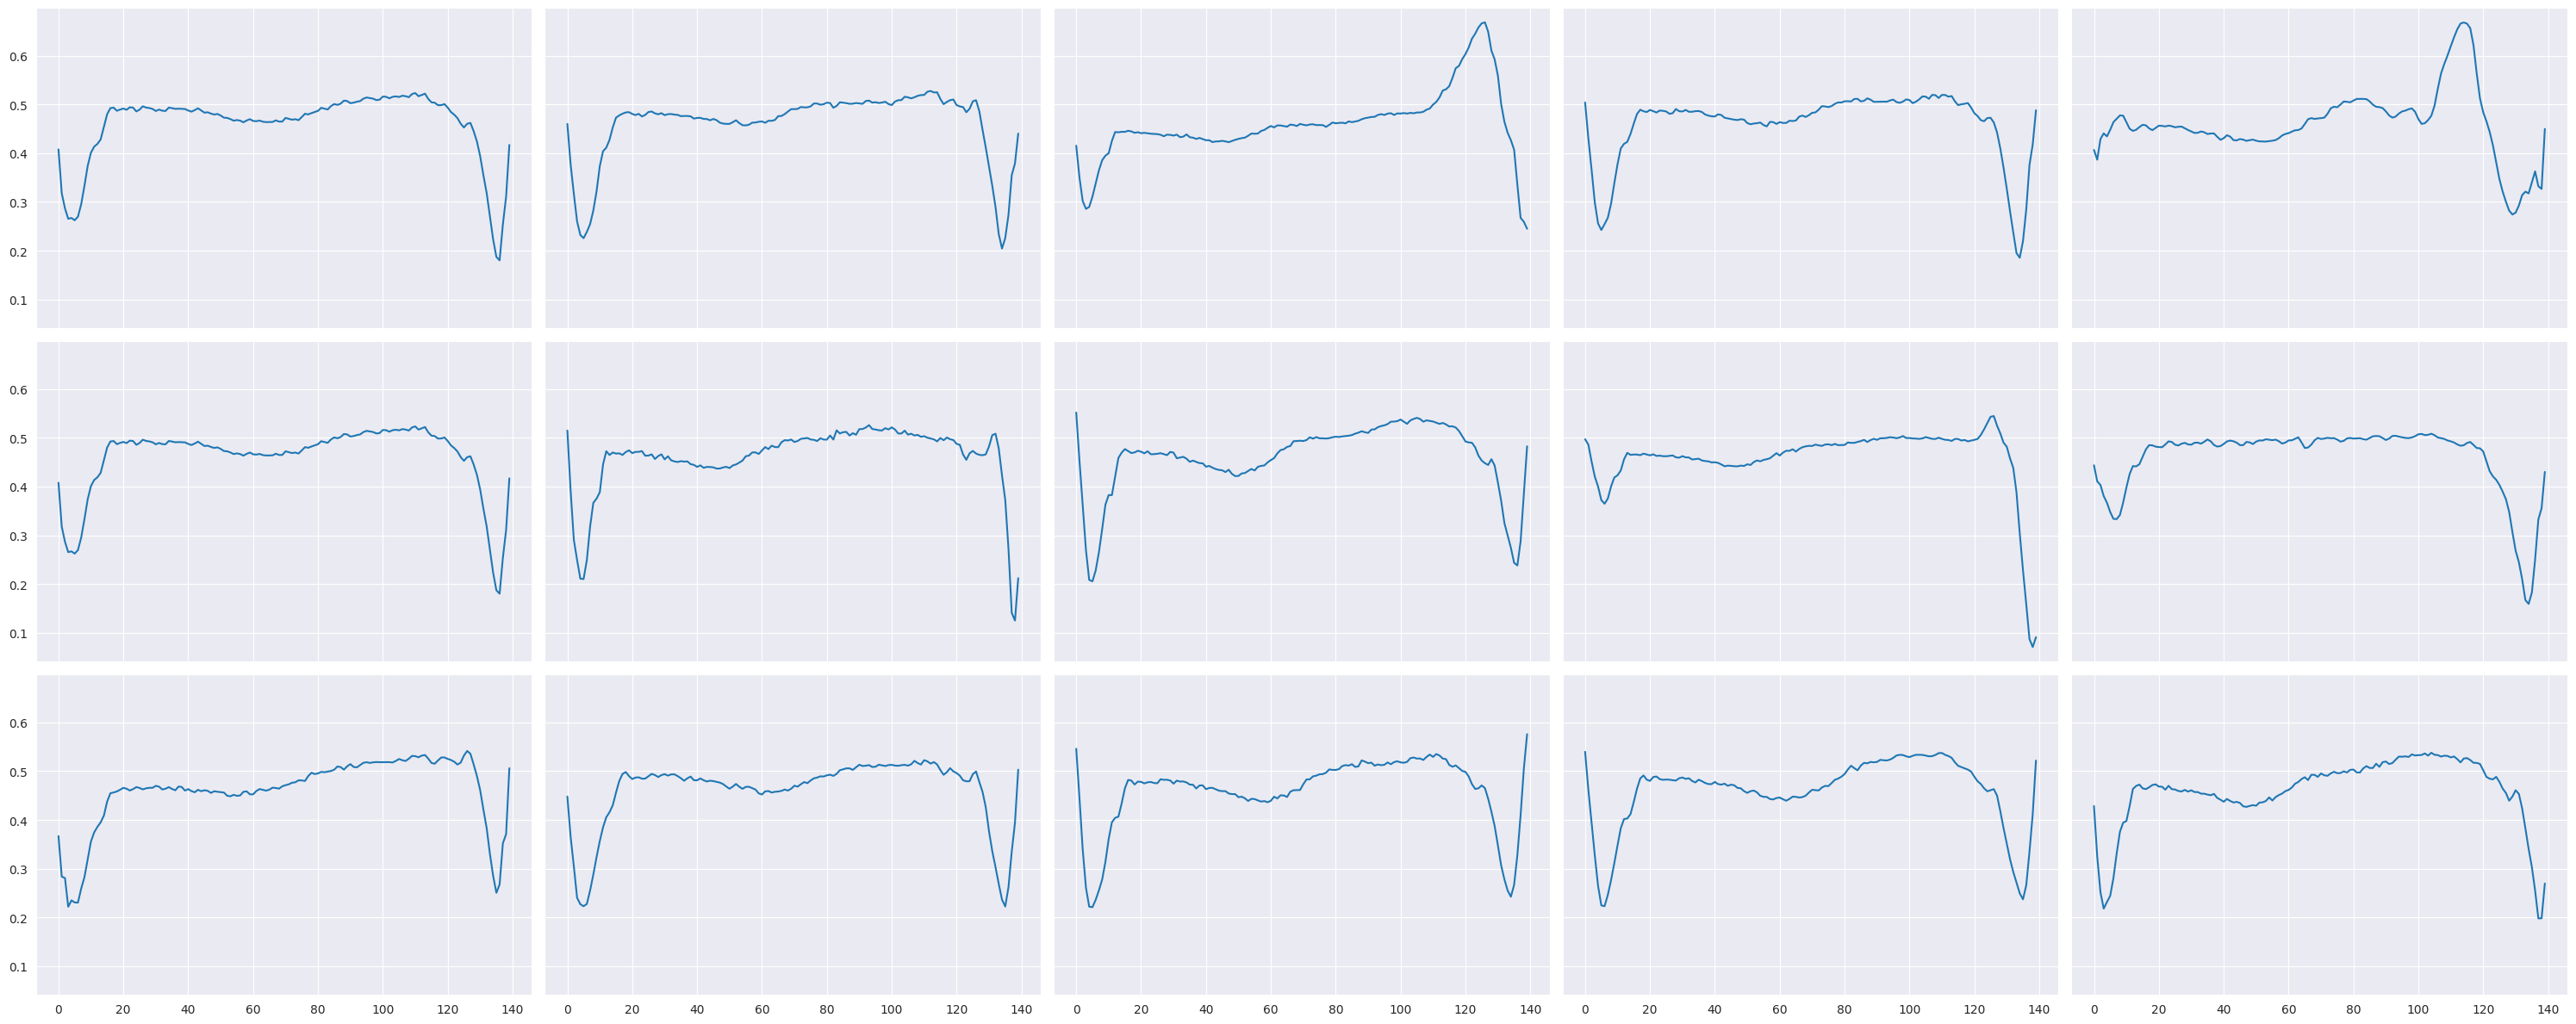

In [ ]:
plot_random_samples(abnormal_train_data, 15)

## Build the model for ECG data

In [ ]:
# Create model class
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = Sequential([
        Dense(32, activation='relu'),
        Dense(15, activation='relu'),
        Dense(8, activation='relu')
    ])
    self.decoder = Sequential([
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
# Instantiate and compile
anomaly_detector = AnomalyDetector()
anomaly_detector.compile(
    loss='mae',
    metrics=['accuracy'],
    optimizer ='adam'
)

In [ ]:
# Fit the model
history = anomaly_detector.fit(
    normal_train_data, normal_train_data, # (since we are interested in accurcy of the reconstruction)
    epochs = 60,
    batch_size=512,
    validation_data=(test_data_norm, test_data_norm), # (lets validate using a dataset with abnormal samples)
    shuffle=True,
)

Epoch 1/60
5/5 [==============================] - 1s 46ms/step - loss: 0.0568 - accuracy: 0.0721 - val_loss: 0.0525 - val_accuracy: 0.0520
Epoch 2/60
5/5 [==============================] - 0s 17ms/step - loss: 0.0536 - accuracy: 0.0725 - val_loss: 0.0510 - val_accuracy: 0.0520
Epoch 3/60
5/5 [==============================] - 0s 14ms/step - loss: 0.0500 - accuracy: 0.0725 - val_loss: 0.0493 - val_accuracy: 0.0520
Epoch 4/60
5/5 [==============================] - 0s 16ms/step - loss: 0.0463 - accuracy: 0.0725 - val_loss: 0.0467 - val_accuracy: 0.0520
Epoch 5/60
5/5 [==============================] - 0s 12ms/step - loss: 0.0428 - accuracy: 0.0725 - val_loss: 0.0450 - val_accuracy: 0.0520
Epoch 6/60
5/5 [==============================] - 0s 17ms/step - loss: 0.0394 - accuracy: 0.0725 - val_loss: 0.0429 - val_accuracy: 0.0520
Epoch 7/60
5/5 [==============================] - 0s 12ms/step - loss: 0.0361 - accuracy: 0.0725 - val_loss: 0.0413 - val_accuracy: 0.0520
Epoch 8/60
5/5 [===========

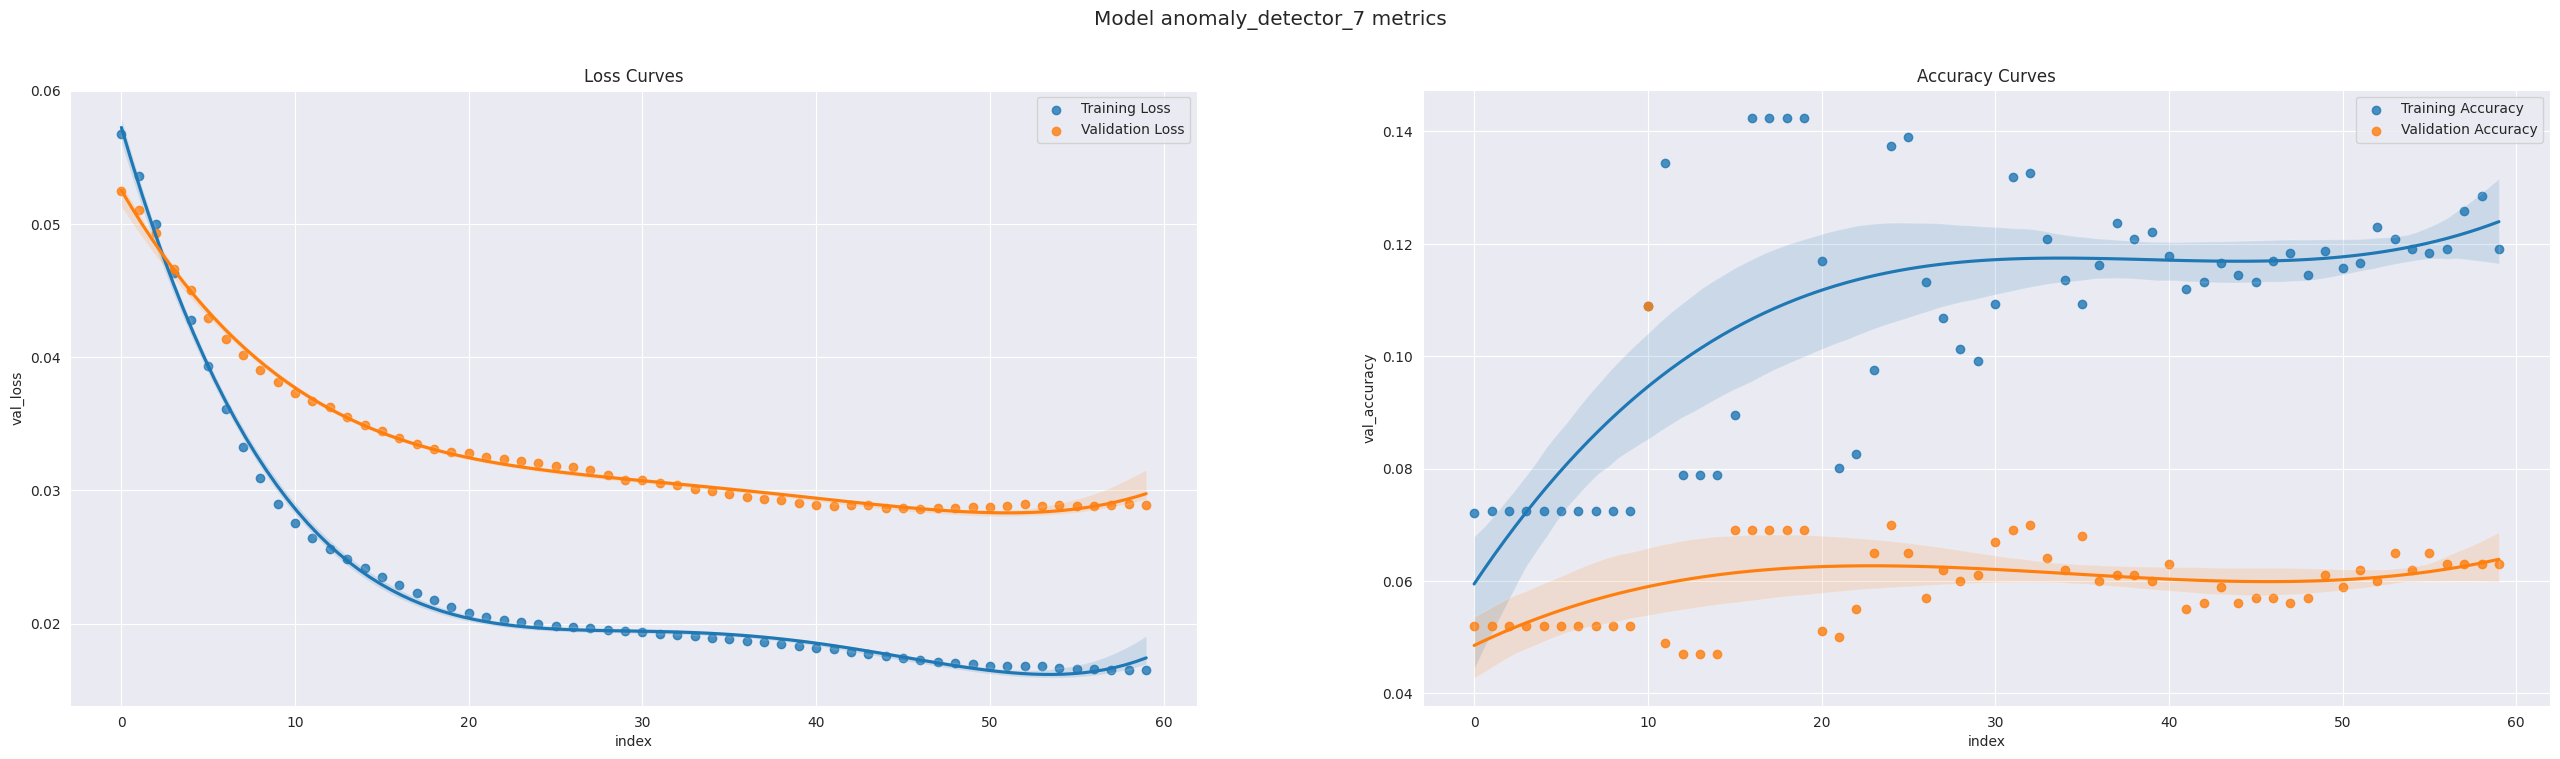

In [ ]:
plot_curves_with_regression(history, order=[4,3])

<p>In tracking anomalies overfitting is not a problem - it is an asset.

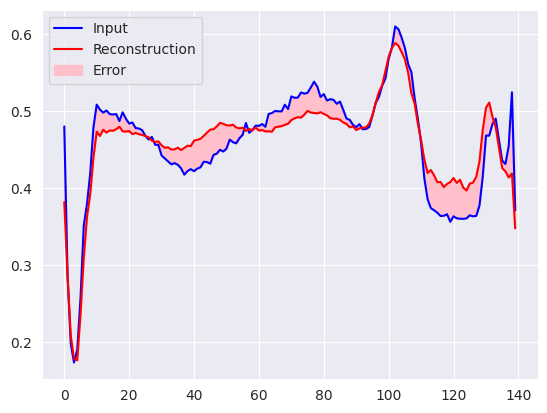

In [ ]:
encoded_imgs = anomaly_detector.encoder(normal_test_data).numpy()
decoded_imgs = anomaly_detector.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(normal_test_data.shape[1]), decoded_imgs[0], normal_test_data[0], color='pink')

plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

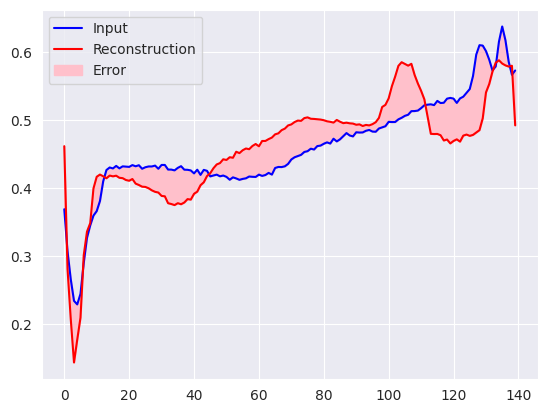

In [ ]:
encoded_imgs = anomaly_detector.encoder(abnormal_test_data).numpy()
decoded_imgs = anomaly_detector.decoder(encoded_imgs).numpy()

plt.plot(abnormal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(abnormal_test_data.shape[1]), decoded_imgs[0], abnormal_test_data[0], color='pink')

plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

74/74 [==============================] - 0s 2ms/step


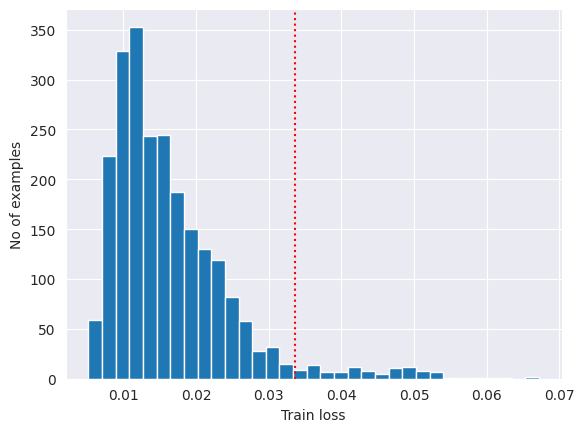

In [ ]:
# Create reconstructions for normal train data
reconstructions = anomaly_detector.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

# Calculate the threshold for normal train data loss
threshold = np.mean(train_loss) + 2*np.std(train_loss)

plt.hist(train_loss[None, :], bins=33)
plt.xlabel('Train loss')
plt.axvline(threshold, ls=':', c='red')
plt.ylabel('No of examples')
plt.show()

14/14 [==============================] - 0s 1ms/step


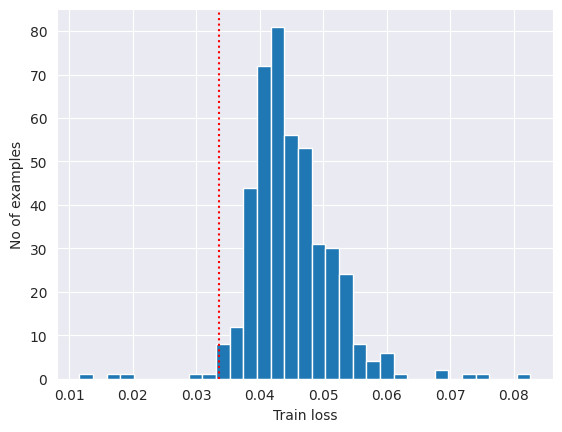

In [ ]:
# Create reconstructions for anomalous test data
reconstructions = anomaly_detector.predict(abnormal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, abnormal_test_data)

plt.hist(train_loss[None, :], bins=33)
plt.xlabel('Train loss')
plt.axvline(threshold, ls=':', c='red')
plt.ylabel('No of examples')
plt.show()